In [1]:
%%capture

import json
import os
os.chdir('..')

from IPython.display import Audio, Markdown, display

from dotenv import load_dotenv
load_dotenv()

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
agent = experiment_utils.create_openai_agent(
    agent_type="voice_memos",
    llm_tag="o3-mini",
    api_key=os.getenv("OPENAI_API_KEY")
)

In [3]:
# create attachment
attachment_id = experiment_utils.create_attachment(
    file_path="tests/integration/voice_memos_01_pt_BR.mp3",
    content_type="audio/mp3"
)

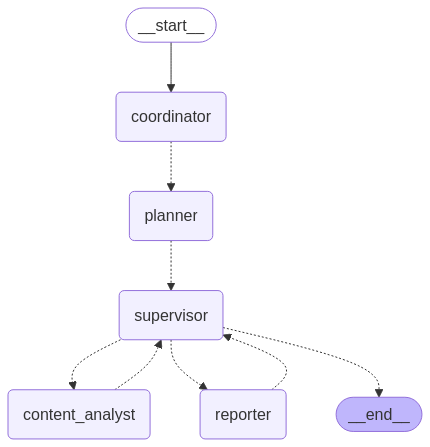

In [4]:
# get agent instance
voice_memos_agent = container.voice_memos_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = voice_memos_agent.get_workflow_builder(agent["id"])
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [5]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Analyse the given audio.",
    agent_id=agent["id"],
    attachment_id=attachment_id
)

inputs = voice_memos_agent.get_input_params(message)
config = voice_memos_agent.get_config(agent["id"])
result = workflow.invoke(inputs, config)
ai_message_content, workflow_state = voice_memos_agent.format_response(result)

In [6]:
file_path="tests/integration/voice_memos_01_pt_BR.mp3"
display(Audio(file_path))

In [7]:
display(Markdown(f"**AI Message Content:**\n\n{ ai_message_content }"))

**AI Message Content:**

**Main Topic:**  
Desenvolvimento e andamento do projeto Agente X.

**Discussed points:**  
- Reunião realizada hoje às 11 horas com Aline da equipe de marketing.  
- Situação do projeto Agente X, que está atrasado.  
- Necessidade de acelerar o desenvolvimento do projeto.  
- Preocupação da equipe de vendas quanto ao prazo de entrega.  
- Importância de apresentar uma atualização na próxima reunião, que ocorrerá na semana que vem.

**Decisions taken:**  
- Acelerar o desenvolvimento do projeto Agente X.  
- Preparar e apresentar uma atualização na próxima reunião.

**Next steps:**  
- Atualização do status do projeto Agente X para a próxima reunião.  
- Seguir com ações que contribuam para reduzir o atraso do projeto.

**Action points:**  
- Equipe de marketing e vendas devem se alinhar para acelerar o desenvolvimento.  
- Preparar as informações e dados necessários para a atualização na próxima reunião.

**Named entities:**  
- Aline – Membro da equipe de marketing.  
- Equipe de vendas – Responsável por monitorar o prazo de entrega.

In [9]:
#display(Markdown(f"**Workflow state:**\n```json\n{ json.dumps(workflow_state, indent=2) }\n```"))
display(Markdown(f"**Structured report:**\n```json\n{ json.dumps(workflow_state['structured_report'], ensure_ascii=False, indent=2) }\n```"))

**Structured report:**
```json
{
  "main_topic": "Desenvolvimento e andamento do projeto Agente X",
  "discussed_points": "Reunião realizada às 11 horas com Aline da equipe de marketing; situação de atraso do projeto Agente X; necessidade de acelerar o desenvolvimento; preocupação da equipe de vendas quanto ao prazo de entrega; importância de apresentar uma atualização na próxima reunião.",
  "decisions_taken": "Acelerar o desenvolvimento do projeto Agente X; preparar e apresentar uma atualização na próxima reunião.",
  "next_steps": "Atualizar o status do projeto Agente X para a próxima reunião; seguir com ações para reduzir o atraso do projeto.",
  "action_points": "Equipe de marketing e vendas devem se alinhar para acelerar o desenvolvimento; preparar as informações e dados necessários para a atualização na próxima reunião.",
  "named_entities": "Aline – Membro da equipe de marketing; Equipe de vendas – Responsável por monitorar o prazo de entrega."
}
```